In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display, HTML

# UMBC CS 471 Project 3: Titanic Survivors with Random Forests

Using a Jupyter notebook like a boss. Already imported pandas and numpy, will import sklearn later. Also the display function for Jupyter notebooks.

## Preprocessing

First thing I had to do was to actually load the data into a dataframe. It's a good thing Pandas has a function just for this. Then just display the head in order to make sure it read in everything.

In [2]:
# Data file is in the same file as the rest.
file_name = "./train.csv"
df = pd.read_csv(file_name)

# Display the head.
display(df.head())

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


Nice so it looks like things loaded in correctly. I looked at an old project I did with the same data set to get what each value meant:

* **Survived:** Outcome of survival (0 = No; 1 = Yes)
* **Pclass:** Socio-economic class (1 = Upper class; 2 = Middle class; 3 = Lower class)
* **Name:** Name of passenger
* **Sex:** Sex of the passenger
* **Age:** Age of the passenger (Some entries contain NaN)
* **SibSp:** Number of siblings and spouses of the passenger aboard
* **Parch:** Number of parents and children of the passenger aboard
* **Ticket:** Ticket number of the passenger
* **Fare:** Fare paid by the passenger
* **Cabin:** Cabin number of the passenger (Some entries contain NaN)
* **Embarked:** Port of embarkation of the passenger (C = Cherbourg; Q = Queenstown; S = Southampton)

Since the **Survived** column is a boolean, lets tell pandas to treat it like one and take a look at the new data frame



In [3]:
df = df.astype({'Survived': bool})
display(df.head())

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,False,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,True,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,True,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,True,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,False,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


Nice! That worked exactly how I wanted it to!

To get a better idea of what the data looks like, lets describe each column's data. That should tell us about any NaN's and whatnot. There are 891 datapoints, so any columns with < 891 data points have missing data. I'm going to both `count()` the values in each column and use `describe()` on all the ones not having `NaN` as the **Age**, since from previous looks, **Age** is the only continuous one with missing data.

In [4]:
df.loc[df["Age"].isnull() == False].describe()

,PassengerId,Pclass,Age,SibSp,Parch,Fare
count,714.000000,714.000000,714.000000,714.000000,714.000000,714.000000
mean,448.582633,2.236695,29.699118,0.512605,0.431373,34.694514
std,259.119524,0.838250,14.526497,0.929783,0.853289,52.918930
min,1.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,222.250000,1.000000,20.125000,0.000000,0.000000,8.050000
50%,445.000000,2.000000,28.000000,0.000000,0.000000,15.741700
75%,677.750000,3.000000,38.000000,1.000000,1.000000,33.375000
max,891.000000,3.000000,80.000000,5.000000,6.000000,512.329200


In [5]:
df.count()

PassengerId    891
Survived       891
Pclass         891
Name           891
Sex            891
Age            714
SibSp          891
Parch          891
Ticket         891
Fare           891
Cabin          204
Embarked       889
dtype: int64

Nice, so the only ones with missing data are **Age**, **Cabin** and **Embarked**. That's pretty good. I do find it kind of weird that the minimum age is a float, especially one that isn't a divisor of 12. Kind of weird but whatever. 

For convenience sake, I want to create a nice little function though that will tell me how many are missing though, so I can use it again. (Got this idea from [here](https://www.analyticsvidhya.com/blog/2016/01/12-pandas-techniques-python-data-manipulation/)). 

Then I'm going to use it on each column (via apply) and print the results, to get a baseline value. Future iterations can just call `print_missing` with the frame in order to check missing values in each column.

In [6]:
def num_missing(x) -> int:
    return sum(x.isnull())

def print_missing(frame):
    print(frame.apply(num_missing, axis=0))
    
print_missing(df)

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64


Nice, that confirms what I already thought about the missing data based on the earlier count.

### Embarked

But I am curious as to why only two embarked values are missing. I'm going to use `loc[]` to see what's special about them.

In [7]:
df.loc[df["Embarked"].isnull()]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
61,62,True,1,"Icard, Miss. Amelie",female,38.0,0,0,113572,80.0,B28,NaN
829,830,True,1,"Stone, Mrs. George Nelson (Martha Evelyn)",female,62.0,0,0,113572,80.0,B28,NaN


Okay that's weird. They were both in the same cabin and ticket. If we were making a really long decision tree, Embarked would almost certainly be a split, but would probably overfit. 

In order to prevent errors later on with `NaN`, I'm just going to set the point of embarktation for those two as `U` for Unknown.

In [8]:
df = df.fillna({"Embarked": "U"})
print_missing(df)

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         0
dtype: int64


Nice! No more missing values in **Embarked**! I believe it's safe to insert dummy values for Embarked, because it's already a category as is. **Age** might be harder since it's a continuous variable, but first I want to look at **Cabin**, which are missing *a lot* but probably have a lot of juicy info. (In fact I don't think I will do anything for age, as it's potentially valuable to know that someone has no age on record.

### Cabin

The first few **Cabin** values all start with a letter, but I don't want to take that for granted, others might have different values. I'm going to do some weird trickery here in order to analyze this. First I want to get a pandas Series containing only non-NaN cabin values.

In [9]:
non_nan_cabins = df.loc[df["Cabin"].isnull() == False]["Cabin"]
non_nan_cabins.count()

204

Nice! That matches what we know should be there. Our earlier count of the non-null values of **Cabin** returned 204, so that's what we were hoping for! Now lets see what all that data looks like. Thankfully, pandas provides a nice vectorized function that should let me run a regex over each part of the series. I can then describe that data, or even make a nice histogram! 

There's a couple things I want to test from a brief look at the CSV in Excel:
* Most Cabins seem to be in the format with a letter and then one or more numbers, so I'll start by counting the number of cabin numbers matching that format in each row.
* I'll check ones that are letters only.
* I'll check ones that are numbers only.
* I also want to check which ones have lower case letters (if any at all).

In [10]:
# First lets import python's regex module.
import re

# Standard regex format (letter + numbers)
std_format_regex = re.compile(r'([A-Z]+)([0-9]+)')
std_format_count = non_nan_cabins.str.count(std_format_regex)
display(std_format_count.describe())

# Letters but no numbers.
no_num_regex = re.compile(r'\b([A-Z]+)(?![A-Z]*[0-9]+)')
no_num_count = non_nan_cabins.str.count(no_num_regex)
display(no_num_count.describe())
        
# Numbers but no letters
no_let_regex = re.compile(r'\b([0-9]+)(?![0-9]*[A-Z]+)')
no_let_count = non_nan_cabins.str.count(no_let_regex)
display(no_let_count.describe())

count    204.000000
mean       1.127451
std        0.519028
min        0.000000
25%        1.000000
50%        1.000000
75%        1.000000
max        4.000000
Name: Cabin, dtype: float64

count    204.000000
mean       0.039216
std        0.194585
min        0.000000
25%        0.000000
50%        0.000000
75%        0.000000
max        1.000000
Name: Cabin, dtype: float64

count    204.0
mean       0.0
std        0.0
min        0.0
25%        0.0
50%        0.0
75%        0.0
max        0.0
Name: Cabin, dtype: float64

The `describe()` function wasn't exactly as helpful as I would've liked, so lets try a different thing using `count()` and `loc()`. I'm not particularly interested in the means and what not, I more so just want to make sure everything is accounted for. Which means removing non-zeros. Though since the third regex looks like it was unneccessary, we can omit that for future tests!

In [11]:
# Lets get a chunk of the nonzero entries.
std_non_zero = std_format_count.nonzero()
nn_non_zero = no_num_count.nonzero()

# Check to see how many got triggered on each
print(len(std_non_zero[0]))
print(len(nn_non_zero[0]))

200
8


That's unexpected... those shouldn't have totaled to more than 204. Looks like the regex isn't perfect, or the data is werider than I thought. Lets turn those into sets and take the union.

In [12]:
snz_set = set(std_non_zero[0])
nnnz_set = set(nn_non_zero[0])

print("Std non zero set len:", len(snz_set))
print("No number non zero set len:", len(nnnz_set))

common = snz_set & nnnz_set
print(common)

Std non zero set len: 200
No number non zero set len: 8
{25, 163, 156, 15}


So the `nonzero` function would have returned the index of the values, so we can just look at those rows of `non_nan_cabins` indivually to see what's special about them.

In [13]:
display(non_nan_cabins.iloc[list(common)])

128    F E69
715    F G73
699    F G63
75     F G73
Name: Cabin, dtype: object

Oh. So it just had both letter only and standard format cabins. I'm not sure if the `F` is part of the cabin description, but that may not matter. I'm going to create a histogram of each of the counts, as well as print out all the columns with lone letters, to help give me a better idea of what to do with them.

715    F G73
327        D
473        D
339        T
75     F G73
128    F E69
292        D
699    F G63
Name: Cabin, dtype: object

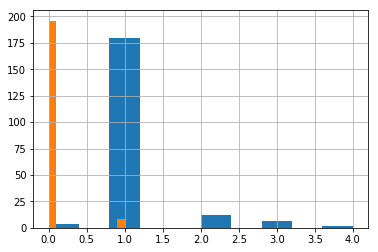

In [14]:
std_format_count.hist()
no_num_count.hist()

display(non_nan_cabins.iloc[list(nnnz_set)])

Nice, that gives me a better idea of what I'm working with. From looking at the sole letters, I'm not sure what to make of what those mean, but I do think I know how I want to categorize the data. (I'll add a few more columns to the table with categories of number of cabins, cabin letter and single letter cabins. We can do more pandas stuff after that. 

In [15]:
df["num_std_cabins"] = std_format_count
df["num_let_cabins"] = no_num_count

df = df.fillna({"num_std_cabins": -1, "num_let_cabins": -1})

df["num_std_cabins"] = df["num_std_cabins"].astype(int)
df["num_let_cabins"] = df["num_let_cabins"].astype(int)

display(df.head())

display(df.loc[df['num_std_cabins'] > 1])

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,num_std_cabins,num_let_cabins
0,1,False,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,-1,-1
1,2,True,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,1,0
2,3,True,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,-1,-1
3,4,True,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,1,0
4,5,False,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,-1,-1


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,num_std_cabins,num_let_cabins
27,28,False,1,"Fortune, Mr. Charles Alexander",male,19.00,3,2,19950,263.0000,C23 C25 C27,S,3,0
88,89,True,1,"Fortune, Miss. Mabel Helen",female,23.00,3,2,19950,263.0000,C23 C25 C27,S,3,0
97,98,True,1,"Greenfield, Mr. William Bertram",male,23.00,0,1,PC 17759,63.3583,D10 D12,C,2,0
118,119,False,1,"Baxter, Mr. Quigg Edmond",male,24.00,0,1,PC 17558,247.5208,B58 B60,C,2,0
297,298,False,1,"Allison, Miss. Helen Loraine",female,2.00,1,2,113781,151.5500,C22 C26,S,2,0
299,300,True,1,"Baxter, Mrs. James (Helene DeLaudeniere Chaput)",female,50.00,0,1,PC 17558,247.5208,B58 B60,C,2,0
305,306,True,1,"Allison, Master. Hudson Trevor",male,0.92,1,2,113781,151.5500,C22 C26,S,2,0
311,312,True,1,"Ryerson, Miss. Emily Borie",female,18.00,2,2,PC 17608,262.3750,B57 B59 B63 B66,C,4,0
341,342,True,1,"Fortune, Miss. Alice Elizabeth",female,24.00,3,2,19950,263.0000,C23 C25 C27,S,3,0
390,391,True,1,"Carter, Mr. William Ernest",male,36.00,1,2,113760,120.0000,B96 B98,S,2,0


Well here's some good news! It looks like non of the people with duplicate cabins have different letters. So I should be safe to just separate out the cabins as I planned. I'm going to create a separate column now, one to store what standard cabin letter they were in and one to store what letter only cabin they were in.

I'm going to want to make this a function in order to use it again for testing data, and I'll use the same regex's I had before.

In [16]:
def get_std_cabin_letter(row):
    match = std_format_regex.match(str(row["Cabin"]))
    if match:
        return match.group(1)
    else:
        return "NA"
    
def get_no_num_cabin_letter(row):
    match = no_num_regex.match(str(row["Cabin"]))
    if match:
        return match.group(1)
    else:
        return "NA"
    
df["std_cabin_letter"] = df.apply(lambda row: get_std_cabin_letter(row), axis=1)
df["no_num_letter"] = df.apply(lambda row: get_no_num_cabin_letter(row), axis=1)
display(df.head())

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,num_std_cabins,num_let_cabins,std_cabin_letter,no_num_letter
0,1,False,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,-1,-1,NA,NA
1,2,True,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,1,0,C,NA
2,3,True,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,-1,-1,NA,NA
3,4,True,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,1,0,C,NA
4,5,False,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,-1,-1,NA,NA


Alright, I think I'm done with preprocessing mostly. The only thing I want to do is to one-hot encode the category values, to make random forests do their things better. I'm also going to normalize the fare prices using sklearn's `MinMaxScaler`. I'm not going to do that with the ages though because their values are in a relatively sane area already and they contain NaN, which doesn't work with sklearn's preprocessor. I'm going to one-hot encode **Pclass** as well, but I don't know if that will be useful or not.

***fuck, you can't have NaN in it.***

fine i'll just fill it with zero and then normalize.

Finally I want to split the **Survived** category into a separate date frame since it is going to be our desired label.

In [17]:
from sklearn.preprocessing import MinMaxScaler

df_final = df
# Initialize a scaler, then apply it to the features
scaler = MinMaxScaler() # default=(0, 1)
df_final['Age'] = df['Age'].fillna(0)
numerical = ['Age', 'Fare']

df_final[numerical] = scaler.fit_transform(df[numerical])

df_final = pd.get_dummies(df, columns=['Pclass', 'Sex', 'Embarked', 'std_cabin_letter', 'no_num_letter'])

outcome = df_final['Survived']
df_final = df_final.drop('Survived', axis=1)


display(df_final.head())
print(df_final.columns)

,PassengerId,Name,Age,SibSp,Parch,Ticket,Fare,Cabin,num_std_cabins,num_let_cabins,...,std_cabin_letter_C,std_cabin_letter_D,std_cabin_letter_E,std_cabin_letter_F,std_cabin_letter_G,std_cabin_letter_NA,no_num_letter_D,no_num_letter_F,no_num_letter_NA,no_num_letter_T
0,1,"Braund, Mr. Owen Harris",0.2750,1,0,A/5 21171,0.014151,NaN,-1,-1,...,0,0,0,0,0,1,0,0,1,0
1,2,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0.4750,1,0,PC 17599,0.139136,C85,1,0,...,1,0,0,0,0,0,0,0,1,0
2,3,"Heikkinen, Miss. Laina",0.3250,0,0,STON/O2. 3101282,0.015469,NaN,-1,-1,...,0,0,0,0,0,1,0,0,1,0
3,4,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0.4375,1,0,113803,0.103644,C123,1,0,...,1,0,0,0,0,0,0,0,1,0
4,5,"Allen, Mr. William Henry",0.4375,0,0,373450,0.015713,NaN,-1,-1,...,0,0,0,0,0,1,0,0,1,0


Index(['PassengerId', 'Name', 'Age', 'SibSp', 'Parch', 'Ticket', 'Fare',
       'Cabin', 'num_std_cabins', 'num_let_cabins', 'Pclass_1', 'Pclass_2',
       'Pclass_3', 'Sex_female', 'Sex_male', 'Embarked_C', 'Embarked_Q',
       'Embarked_S', 'Embarked_U', 'std_cabin_letter_A', 'std_cabin_letter_B',
       'std_cabin_letter_C', 'std_cabin_letter_D', 'std_cabin_letter_E',
       'std_cabin_letter_F', 'std_cabin_letter_G', 'std_cabin_letter_NA',
       'no_num_letter_D', 'no_num_letter_F', 'no_num_letter_NA',
       'no_num_letter_T'],
      dtype='object')


## Parameters

Alright, time for the next step of the project! I'm going to throw out the columns **PassengerId**, **Name** and **Ticket** right away because there's not really any information to be gained from them since they are just artificial values, or (in the case of Ticket) something I can't really make any sense of.

I'm also going to throw out the Cabin column since I've already gotten everything I needed out of that.

In [18]:
to_drop = ['PassengerId', 'Name', 'Ticket', 'Cabin']
df_final = df_final.drop(to_drop, axis=1)

display(df_final.head())
print(df_final.columns)

,Age,SibSp,Parch,Fare,num_std_cabins,num_let_cabins,Pclass_1,Pclass_2,Pclass_3,Sex_female,...,std_cabin_letter_C,std_cabin_letter_D,std_cabin_letter_E,std_cabin_letter_F,std_cabin_letter_G,std_cabin_letter_NA,no_num_letter_D,no_num_letter_F,no_num_letter_NA,no_num_letter_T
0,0.2750,1,0,0.014151,-1,-1,0,0,1,0,...,0,0,0,0,0,1,0,0,1,0
1,0.4750,1,0,0.139136,1,0,1,0,0,1,...,1,0,0,0,0,0,0,0,1,0
2,0.3250,0,0,0.015469,-1,-1,0,0,1,1,...,0,0,0,0,0,1,0,0,1,0
3,0.4375,1,0,0.103644,1,0,1,0,0,1,...,1,0,0,0,0,0,0,0,1,0
4,0.4375,0,0,0.015713,-1,-1,0,0,1,0,...,0,0,0,0,0,1,0,0,1,0


Index(['Age', 'SibSp', 'Parch', 'Fare', 'num_std_cabins', 'num_let_cabins',
       'Pclass_1', 'Pclass_2', 'Pclass_3', 'Sex_female', 'Sex_male',
       'Embarked_C', 'Embarked_Q', 'Embarked_S', 'Embarked_U',
       'std_cabin_letter_A', 'std_cabin_letter_B', 'std_cabin_letter_C',
       'std_cabin_letter_D', 'std_cabin_letter_E', 'std_cabin_letter_F',
       'std_cabin_letter_G', 'std_cabin_letter_NA', 'no_num_letter_D',
       'no_num_letter_F', 'no_num_letter_NA', 'no_num_letter_T'],
      dtype='object')


### Cross Validation

Alright, time to set up cross validation. I'm going to use ten-fold cross validation because there isn't much data to work with. I'm going to have sklearn shuffle it first though, because I don't know who entered the CSV originally so there may be some meaning to it. I am going to set a random state at the beginning though so I can be consistent and compare my results as I tweak parameters.

In [19]:
from sklearn.model_selection import KFold
from collections import namedtuple

K_Split = namedtuple('K_Split', ['X_test', 'X_train', 'y_test', 'y_train'])

RANDOM_STATE = 1337

kf = KFold(n_splits=10, shuffle=True, random_state=RANDOM_STATE)

X = df_final
y = outcome

### Accuracy

So in order to calculate the accuracy, I'm going to use the `accuracy_score` from `sklearn` because that's what I've used before when working with data like this. Since it doesn't really matter whether I correctly predict someone living or dying, the accuracy should be fine. 

In order to have a good baseline, I'm going to use the actual percentage of who survived the Titanic, which is easy enough. However, I can't use everything being categorized as correct for this, because then the accuracy and fbeta will just be 1! So instead I'm going to make the naive model kill everyone, since most people on the titanic died. 

The Positive will be someone surviving and the negative will be someone not surviving in the real life scenario, but since I can't do that with precision scores, 

Then I'm going to have to calculate the first accuracy and fbeta scores myself since sklearn can't do that.

In [21]:
naive_TP = 0
naive_FP = 0

naive_TN = outcome.count() - np.sum(outcome)
naive_FN = np.sum(outcome)

naive_accuracy = (naive_TP + naive_TN) / (naive_TP + naive_FP + naive_TN + naive_FN)
lazy_max_accuracy = .70

# Print the results 
print("Naive Predictor: [Accuracy score: {:.4f}]".format(naive_accuracy))

Naive Predictor: [Accuracy score: 0.6162]


That's some neat accuracy, espectally since the accuracy you put in the project description was just 70%. 

So time to do some stuff. I want to make a generic function that I can use to train any model and any split. So lets make that.

In [22]:
from sklearn.metrics import accuracy_score

# Returns the accuracy score.
def train_test_single_split(learner, X_train, X_test, y_train, y_test):
    learner = learner.fit(X_train, y_train)
    predictions = learner.predict(X_test)
    return accuracy_score(y_test, predictions)

def train_test_kfold(learner, X, y, kf):
    scores = []
    for train_index, test_index in kf.split(X):
        X_train, y_train = X.iloc[train_index], y.iloc[train_index]
        X_test, y_test = X.iloc[test_index], y.iloc[test_index]
        single_score = train_test_single_split(learner, X_train, X_test, y_train, y_test)
        scores += [single_score]
    return sum(scores) / len(scores)

Okay lets actually do the stuff now. I'm running out of time :(

I'm going to use some of sklearn's fancy libraries to do the work for me.

[This](https://i.imgur.com/jwBKz6t.jpg) is basically me. Minus the google part, rip host matching. oh and minus the not sklearn thing, that too. but same deal.

Okay I hope my laptop doesn't catch on fire here.

In [ ]:
from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer

clf = RandomForestClassifier(random_state=RANDOM_STATE)

# tbh i'd rather use fbeta but w/e
scorer = make_scorer(accuracy_score)

parameters = {
    'n_estimators': [5, 10, 15, 25],
    'criterion': ['gini', 'entropy'],
    'max_features': ['auto', 'sqrt', 'log2', None],
    'max_depth': [None, 2, 4, 8]
}



# yeah idk if anything else should be added, knock yourself out.

# tfw you forget the random state the first time
# tfw gridsearch doesn't actually take a random state
grid = GridSearchCV(clf, param_grid=parameters, scoring=scorer, cv=kf)

grid.fit(X, y)

# nearly named this the "chad_clf"
best_clf = grid.best_estimator_

best_accuracy = train_test_kfold(best_clf, X, y, kf)

print("Best accuracy:", best_accuracy)

yeah okay that's good enough for tonight. confusion matricies are overrated, idk even know how to do that for kfold.

oh yeah my computer is not on fire but it is certainly not happy, i've been waiting like 10 minutes now or something idk.

yeah i can get the best parameters too if this **ever finishes running**

holy fuck it just finished with a FUCKING ERROR

okay so apparently grid search doesn't take a random_state that is... annoying.

In [ ]:
best_params = grid.best_params_
best_score = grid.best_score_

print("The GridSearchCV found the best number of estimators to be: {}, the best criterion to be: {}, the best max_features to be: {} and the best max_depth to be: {}".format(best_params['n_estimators'], best_params['criterion'], best_params['max_features'], best_params['max_depth']))
print("The final GridSearch RandomForest accuracy was: {:.4f}".format(best_score))